In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pydataset import data
from sklearn.preprocessing import MinMaxScaler

import wrangle as w

## 1.) Load the tips dataset.

In [4]:
tips_df = data('tips')

In [5]:
tips_df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [6]:
w.check_columns(tips_df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
2,sex,2,"[Female, Male]",0,0.0,object
3,smoker,2,"[No, Yes]",0,0.0,object
5,time,2,"[Dinner, Lunch]",0,0.0,object
4,day,4,"[Sun, Sat, Thur, Fri]",0,0.0,object
6,size,6,"[2, 3, 4, 1, 6, 5]",0,0.0,int64
1,tip,123,"[1.01, 1.66, 3.5, 3.31, 3.61, 4.71, 2.0, 3.12, 1.96, 3.23, 1.71, 5.0, 1.57, 3.0, 3.02,...",0,0.0,float64
0,total_bill,229,"[16.99, 10.34, 21.01, 23.68, 24.59, 25.29, 8.77, 26.88, 15.04, 14.78, 10.27, 35.26, 15...",0,0.0,float64


## 1a.) Create a column named price_per_person. This should be the total bill divided by the party size.

In [7]:
tips_df['price_per_person'] = round(tips_df.total_bill / tips_df['size'], 2)


In [8]:
tips_df.head(3)

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,8.49
2,10.34,1.66,Male,No,Sun,Dinner,3,3.45
3,21.01,3.50,Male,No,Sun,Dinner,3,7.00


In [9]:
dummies = ['sex', 'smoker', 'day', 'time']
dummy_df = pd.get_dummies(tips_df[dummies], dtype=int, drop_first=True)
tips_df = pd.concat([tips_df, dummy_df], axis=1)

In [10]:
tips_df.head(2)


,total_bill,tip,sex,smoker,day,time,size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
1,16.99,1.01,Female,No,Sun,Dinner,2,8.49,0,0,0,1,0,0
2,10.34,1.66,Male,No,Sun,Dinner,3,3.45,1,0,0,1,0,0


In [12]:
tips_df = tips_df.drop(columns=dummies)


In [13]:
tips_df.head(2)

,total_bill,tip,size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
1,16.99,1.01,2,8.49,0,0,0,1,0,0
2,10.34,1.66,3,3.45,1,0,0,1,0,0


In [14]:
train, validate, test = w.split_continuous(tips_df)

Train: 0.5573770491803278
Validate: 0.24180327868852458
Test: 0.20081967213114754


In [15]:
# #split into my X_train and y_train
X_train = train.drop(columns=['tip'])
y_train = train.tip

X_validate = validate.drop(columns=['tip'])
y_validate = validate.tip

X_test = test.drop(columns=['tip'])
y_test = test.tip

In [16]:
X_train.shape


(136, 9)

In [17]:
X_train_scaled = X_train.copy()
col_to_scale = ['total_bill', 'price_per_person']
scaler = MinMaxScaler()
X_train_scaled[col_to_scale] = scaler.fit_transform(X_train[col_to_scale])

In [18]:
X_train_scaled.head()

,total_bill,size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
207,0.492669,3,0.336628,1,1,1,0,0,0
164,0.224969,2,0.222674,1,0,0,1,0,0
210,0.202974,2,0.192442,0,1,1,0,0,0
76,0.155844,2,0.127326,1,0,1,0,0,0
225,0.216799,2,0.211628,1,1,0,0,0,1


## 1b.) Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount?

In [19]:
# i would think the bill total

<Axes: >

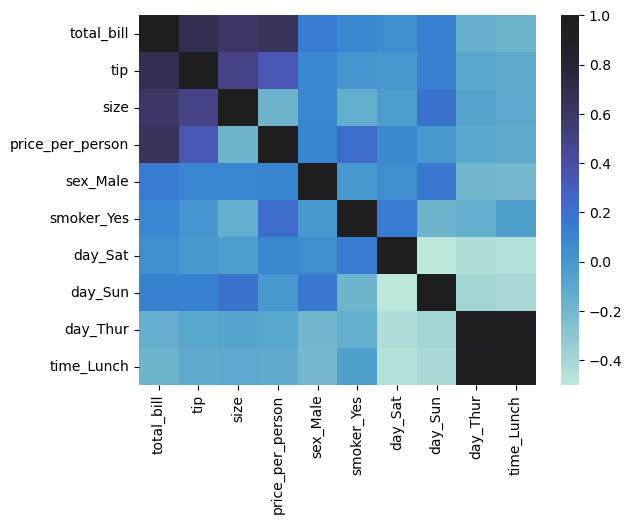

In [20]:
sns.heatmap(tips_df.corr(), center= 1)

## 1c.) Use Select K Best to select the top 2 features for predicting tip amount. What are they?


In [21]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 2 features
f_selector = SelectKBest(f_regression, k=2)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [22]:
print(f' The 2 best features are {f_feature}')


 The 2 best features are ['total_bill', 'size']


## 1d.) Use Recursive Feature Elimination to select the top 2 features for tip amount. What are they?

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=2)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()


In [24]:
print(f' The 2 best features: {rfe_feature}')

 The 2 best features: ['total_bill', 'price_per_person']


## 1e.) Why do you think Select K Best and Recursive Feature Elimination might give different answers for the top features? Does this change as you change the number of features you are selecting?

I think that rfe gives a different answer based on using regression to help calculate the feature.

In [25]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=4)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [26]:
print(f' The 4 best features: {rfe_feature}')

 The 4 best features: ['total_bill', 'size', 'price_per_person', 'day_Thur']


Using more than 2 features definitely has an affect on the feature results.

## 2.) Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [27]:
def select_kbest(X, y, num_feat):
   
    # parameters: f_regression stats test, give me 2 features
    f_selector = SelectKBest(f_regression, k=num_feat)

    # find the top 8 X's correlated with y
    f_selector.fit(X, y)

    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()

    # get list of top K features. 
    f_feature = X.iloc[:,feature_mask].columns.tolist()
    print(f'The best {num_feat} features are {f_feature}')
    return f_feature

In [28]:
select_kbest(X_train_scaled, y_train, num_feat=3)

The best 3 features are ['total_bill', 'size', 'price_per_person']


['total_bill', 'size', 'price_per_person']

## 3.) Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top n features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [29]:
def rfe(X, y, num_feat):
    lm = LinearRegression()

    # create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
    rfe = RFE(lm, n_features_to_select=num_feat)

    # fit the data using RFE
    rfe.fit(X,y)  

    # get the mask of the columns selected
    feature_mask = rfe.support_

    # get list of the column names. 
    rfe_feature = X.iloc[:,feature_mask].columns.tolist()

    print(f'The best {num_feat}  are {rfe_feature}')
    return rfe_feature

In [31]:
rfe(X_train_scaled, y_train, num_feat=3)

The best 3  are ['total_bill', 'size', 'price_per_person']


['total_bill', 'size', 'price_per_person']

## 4.) Load the swiss dataset and use all the other features to predict Fertility. Find the top 3 features using both Select K Best and Recursive Feature Elimination (use the functions you just built to help you out).

In [32]:
swiss_df = data('swiss')

In [33]:
swiss_df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [34]:
w.check_columns(swiss_df)

,Column Name,Number of Unique Values,Unique Values,Number of Null Values,Proportion of Null Values,dtype
3,Education,19,"[12, 9, 5, 7, 15, 8, 13, 6, 2, 28, 20, 10, 3, 1, 19, 11, 32, 53, 29]",0,0.0,int64
2,Examination,22,"[15, 6, 5, 12, 17, 9, 16, 14, 21, 19, 22, 18, 26, 31, 20, 25, 3, 7, 13, 29, 35, 37]",0,0.0,int64
5,Infant.Mortality,37,"[22.2, 20.2, 20.3, 20.6, 26.6, 23.6, 24.9, 21.0, 24.4, 24.5, 16.5, 19.1, 22.7, 18.7, 2...",0,0.0,float64
0,Fertility,46,"[80.2, 83.1, 92.5, 85.8, 76.9, 76.1, 83.8, 92.4, 82.4, 82.9, 87.1, 64.1, 66.9, 68.9, 6...",0,0.0,float64
4,Catholic,46,"[9.96, 84.84, 93.4, 33.77, 5.16, 90.57, 92.85, 97.16, 97.67, 91.38, 98.61, 8.52, 2.27,...",0,0.0,float64
1,Agriculture,47,"[17.0, 45.1, 39.7, 36.5, 43.5, 35.3, 70.2, 67.8, 53.3, 45.2, 64.5, 62.0, 67.5, 60.7, 6...",0,0.0,float64


In [35]:
swiss_df.rename(columns={swiss_df.columns[5]: 'infant_mortality'}, inplace=True)

In [36]:
swiss_df.head(2)

,Fertility,Agriculture,Examination,Education,Catholic,infant_mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2


In [37]:
train, validate, test = w.split_continuous(swiss_df)


Train: 0.5319148936170213
Validate: 0.2553191489361702
Test: 0.2127659574468085


In [38]:
# #split into my X_train and y_train
X_train = train.drop(columns=['Fertility'])
y_train = train.Fertility

X_validate = validate.drop(columns=['Fertility'])
y_validate = validate.Fertility

X_test = test.drop(columns=['Fertility'])
y_test = test.Fertility

In [39]:
X_train_scaled = X_train.copy()
col_to_scale = ['Agriculture', 'Examination', 'Education', 'Catholic', 'infant_mortality']
scaler = MinMaxScaler()
X_train_scaled[col_to_scale] = scaler.fit_transform(X_train[col_to_scale])

In [40]:
select_kbest(X_train_scaled, y_train, num_feat=3)

The best 3 features are ['Examination', 'Education', 'Catholic']


['Examination', 'Education', 'Catholic']

In [41]:
rfe(X_train_scaled, y_train, num_feat=3)

The best 3  are ['Agriculture', 'Education', 'infant_mortality']


['Agriculture', 'Education', 'infant_mortality']